In [1]:
import os
from PIL import Image, ImageEnhance
import numpy as np
from torchvision import transforms
from collections import defaultdict
import shutil
import torchvision.transforms as T
from torchvision import models, datasets
from torch.utils.data import DataLoader
import random
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
from sklearn.metrics import classification_report, confusion_matrix
import time
from sklearn.metrics import accuracy_score, classification_report
import torch.optim as optim
import torchvision.models as models
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, random_split
import seaborn as sns
import matplotlib.pyplot as plt
import zipfile

In [2]:
%matplotlib inline

In [3]:
dataset_path = "/user/pgnanase/alzheimer_dataset"

for root_file, directory, files in os.walk(dataset_path):
    print("Root:", root_file)
    print("Directories:", directory)
    print("Files:", files[:5])

image_classes = [os.path.join(dataset_path, folder) for folder in os.listdir(dataset_path)
                 if os.path.isdir(os.path.join(dataset_path, folder))]

print("Found folders:", image_classes)

Root: /user/pgnanase/alzheimer_dataset
Directories: ['Mild Dementia', 'Moderate Dementia', 'Non Demented', 'Very mild Dementia']
Files: []
Root: /user/pgnanase/alzheimer_dataset/Mild Dementia
Directories: []
Files: ['OAS1_0028_MR1_mpr-1_100.jpg', 'OAS1_0028_MR1_mpr-1_101.jpg', 'OAS1_0028_MR1_mpr-1_102.jpg', 'OAS1_0028_MR1_mpr-1_103.jpg', 'OAS1_0028_MR1_mpr-1_104.jpg']
Root: /user/pgnanase/alzheimer_dataset/Moderate Dementia
Directories: []
Files: ['OAS1_0308_MR1_mpr-1_100.jpg', 'OAS1_0308_MR1_mpr-1_101.jpg', 'OAS1_0308_MR1_mpr-1_102.jpg', 'OAS1_0308_MR1_mpr-1_103.jpg', 'OAS1_0308_MR1_mpr-1_104.jpg']
Root: /user/pgnanase/alzheimer_dataset/Non Demented
Directories: []
Files: ['OAS1_0001_MR1_mpr-1_100.jpg', 'OAS1_0001_MR1_mpr-1_101.jpg', 'OAS1_0001_MR1_mpr-1_102.jpg', 'OAS1_0001_MR1_mpr-1_103.jpg', 'OAS1_0001_MR1_mpr-1_104.jpg']
Root: /user/pgnanase/alzheimer_dataset/Very mild Dementia
Directories: []
Files: ['OAS1_0003_MR1_mpr-1_100.jpg', 'OAS1_0003_MR1_mpr-1_101.jpg', 'OAS1_0003_MR1_mpr

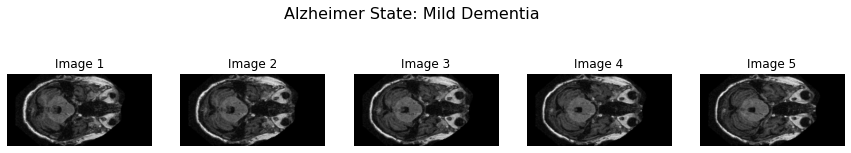

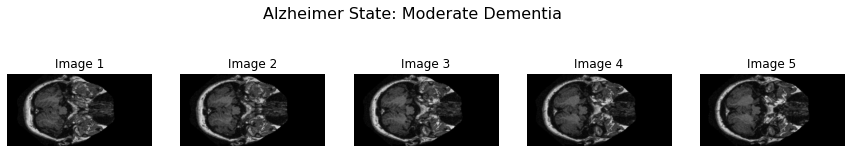

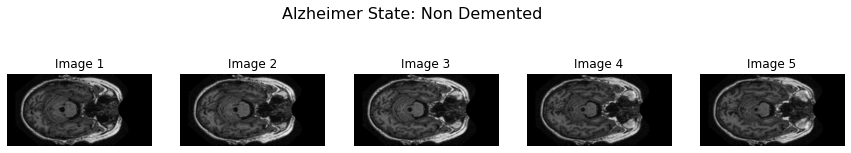

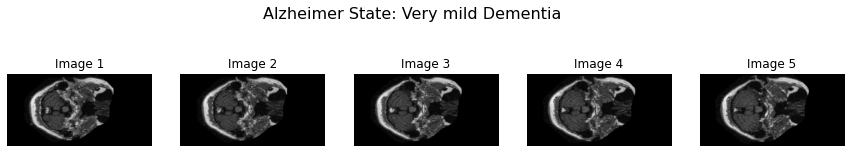

In [4]:
for folder in image_classes:
    images = [f for f in os.listdir(folder) if f.lower().endswith('.jpg')]
    images = images[:5]

    plt.figure(figsize=(15, 3))
    plt.suptitle(f"Alzheimer State: {os.path.basename(folder)}", fontsize=16)

    for cnt, image_name in enumerate(images):
        image_location = os.path.join(folder, image_name)
        img = Image.open(image_location)

        plt.subplot(1, 5, cnt + 1)
        plt.imshow(img)
        plt.axis("off")
        plt.title(f"Image {cnt+1}")

    plt.show()

<Figure size 1080x216 with 0 Axes>

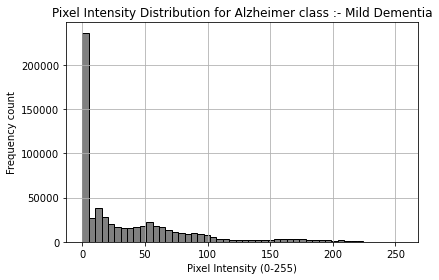

<Figure size 1080x216 with 0 Axes>

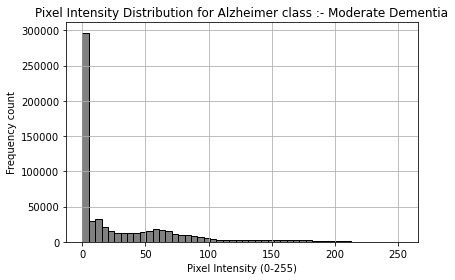

<Figure size 1080x216 with 0 Axes>

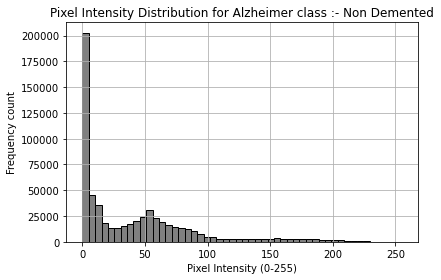

<Figure size 1080x216 with 0 Axes>

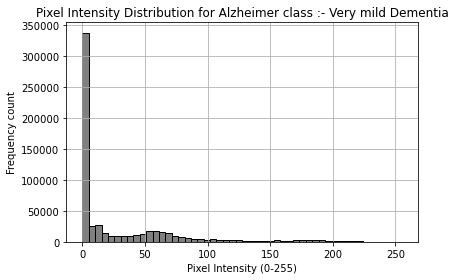

In [5]:
for folder in image_classes:
    class_name = os.path.basename(folder)
    image_files = [f for f in os.listdir(folder) if f.lower().endswith('.jpg')]
    image_files = image_files[:5]

    plt.figure(figsize=(15, 3))
    plt.suptitle(f"Alzheimer State: {class_name} - Sample Class Images", fontsize=16)

    pixel_intensity_values = []
    for image_name in image_files:
        image_location = os.path.join(folder, image_name)
        img = Image.open(image_location).convert("L")
        pixel_intensity_values.extend(np.array(img).flatten())

    plt.figure(figsize=(6, 4))
    plt.hist(pixel_intensity_values, bins=50, color='gray', edgecolor='black')
    plt.title(f"Pixel Intensity Distribution for Alzheimer class :- {class_name}")
    plt.xlabel("Pixel Intensity (0-255)")
    plt.ylabel("Frequency count")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [6]:
class_image_counts = defaultdict(int)
image_sizes = []

for folder in image_classes:
    class_name = os.path.basename(folder)
    for image_name in os.listdir(folder):
        if image_name.lower().endswith('.jpg'):
            img_location = os.path.join(folder, image_name)
            class_image_counts[class_name] += 1

            try:
                with Image.open(img_location) as img:
                    image_sizes.append(img.size)
            except:
                print(f"Could not open image: {img_location}")

total_images = sum(class_image_counts.values())

widths, heights = zip(*image_sizes)
mean_size = (np.mean(widths), np.mean(heights))
min_size = (np.min(widths), np.min(heights))
max_size = (np.max(widths), np.max(heights))

print("ALZEIMER DATASET SUMMARY")
print("---------------------")
print(f"Total images  Count    : {total_images}")
print(f"Number of Alzeimer classes : {len(class_image_counts)}")
print("Images per Alzeimer class  :")
for class_name, count in class_image_counts.items():
    print(f"  - {class_name}: {count} images")

print("\nImage Size Info")
print(f"Average Image size      : {mean_size[0]:.1f} x {mean_size[1]:.1f}")
print(f"Min Image size          : {min_size[0]} x {min_size[1]}")
print(f"Max Image size          : {max_size[0]} x {max_size[1]}")


ALZEIMER DATASET SUMMARY
---------------------
Total images  Count    : 100947
Number of Alzeimer classes : 4
Images per Alzeimer class  :
  - Mild Dementia: 10000 images
  - Moderate Dementia: 10000 images
  - Non Demented: 67222 images
  - Very mild Dementia: 13725 images

Image Size Info
Average Image size      : 496.0 x 248.0
Min Image size          : 496 x 248
Max Image size          : 496 x 248


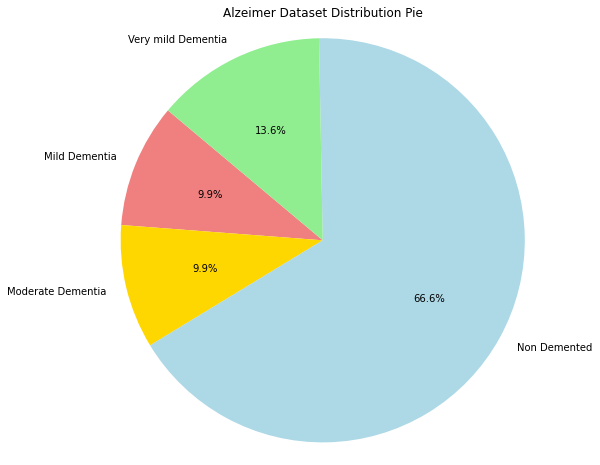

In [7]:
labels = list(class_image_counts.keys())
sizes = list(class_image_counts.values())
colors = ['lightcoral', 'gold', 'lightblue', 'lightgreen']

plt.figure(figsize=(8, 8))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', colors=colors, startangle=140)
plt.title("Alzeimer Dataset Distribution Pie")
plt.axis('equal')
plt.show()


In [8]:
target__class_count = 10000
augmentation_classes = ["Moderate Dementia", "Mild Dementia"]

augmentation_transformation = transforms.Compose([
    transforms.RandomRotation(10),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
])

def augment_image(img):
    return augmentation_transformation(img)

for folder in image_classes:
    class_name = os.path.basename(folder)

    if class_name in augmentation_classes:
        existing_images = [f for f in os.listdir(folder) if f.lower().endswith('.jpg')]
        current_count = len(existing_images)

        print(f"Augmenting Alzeimer Class Images for '{class_name}': {current_count} → {target__class_count}")
        image_cnt = 0

        while len(os.listdir(folder)) < target__class_count:
            image_name = existing_images[image_cnt % current_count]
            image_loc = os.path.join(folder, image_name)

            with Image.open(image_loc) as img:
                img = img.convert("RGB")

                aug_img = augment_image(img)

                aug_img_name = f"aug_{image_cnt}_{image_name}"
                aug_img_path = os.path.join(folder, aug_img_name)
                aug_img.save(aug_img_path)

            image_cnt += 1

print("Data augmentation process completed.")

Augmenting Alzeimer Class Images for 'Mild Dementia': 10000 → 10000
Augmenting Alzeimer Class Images for 'Moderate Dementia': 10000 → 10000
Data augmentation process completed.


In [11]:
# dataset_path = "/projects/academic/courses/cse676s25/pgulhane/alzheimer_dataset"
labelled_path = "/user/pgnanase/alzheimer_dataset_labelled"
unlabelled_path = "/user/pgnanase/alzheimer_dataset_unlabelled"


os.makedirs(labelled_path, exist_ok=True)
os.makedirs(unlabelled_path, exist_ok=True)
random.seed(42)

for class_name in os.listdir(dataset_path):
    class_folder_path = os.path.join(dataset_path, class_name)
    if not os.path.isdir(class_folder_path):
        continue

    image_files = [f for f in os.listdir(class_folder_path) if f.lower().endswith('.jpg')]
    random.shuffle(image_files)

    labelled_files = image_files[:450]
    unlabelled_files = image_files[450:]

    labelled_class_path = os.path.join(labelled_path, class_name)
    os.makedirs(labelled_class_path, exist_ok=True)

    for fname in labelled_files:
        src = os.path.join(class_folder_path, fname)
        dst = os.path.join(labelled_class_path, fname)
        shutil.copy2(src, dst)

    for fname in unlabelled_files:
        src = os.path.join(class_folder_path, fname)
        dst = os.path.join(unlabelled_path, f"{class_name.replace(' ', '_')}_{fname}")
        shutil.copy2(src, dst)

print("Data split completed.")


Data split completed.


In [12]:
print("Dataset after Splitting into Labelled and Unlabelled images")
print("LABELLED DATASET")
print("-----------------")

for class_name in os.listdir(labelled_path):
    class_folder = os.path.join(labelled_path, class_name)
    if os.path.isdir(class_folder):
        num_images = len([f for f in os.listdir(class_folder) if f.lower().endswith(('.jpg','.png'))])
        print(f"  - {class_name}: {num_images} images")

# unlabelled_images = [f for f in os.listdir(unlabelled_path) if f.lower().endswith('.jpg')]

# print("\nUNLABELLED DATASET")
# print("-------------------")
# print(f"Total unlabelled images: {len(unlabelled_images)}")


Dataset after Splitting into Labelled and Unlabelled images
LABELLED DATASET
-----------------
  - Mild Dementia: 450 images
  - Moderate Dementia: 450 images
  - Non Demented: 450 images
  - Very mild Dementia: 450 images


In [13]:
import os
import random
from PIL import Image
from torchvision import transforms


augment = transforms.Compose([
    transforms.RandomRotation(15),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
])

def upsample_class_images(class_dir, target_count=450):
    image_files = [f for f in os.listdir(class_dir) if f.lower().endswith(('.jpg', '.png'))]
    current_count = len(image_files)

    if current_count >= target_count:
        return

    print(f"Upsampling {os.path.basename(class_dir)} from {current_count} to {target_count} images...")

    i = 0
    while len(os.listdir(class_dir)) < target_count:
        img_name = random.choice(image_files)
        img_path = os.path.join(class_dir, img_name)
        image = Image.open(img_path).convert('RGB')
        augmented_image = augment(image)

        new_name = f"aug_{i}_{img_name}"
        new_path = os.path.join(class_dir, new_name)
        augmented_image.save(new_path)
        i += 1

In [14]:
# dataset_path = "/user/rishabda/alzheimer_dataset_labelled"

for root_file, directory, files in os.walk(dataset_path):
    print("Root:", root_file)
    print("Directories:", directory)
    print("Files:", files[:5])

image_classes = [os.path.join(dataset_path, folder) for folder in os.listdir(dataset_path)
                 if os.path.isdir(os.path.join(dataset_path, folder))]

print("Found folders:", image_classes)

Root: /user/pgnanase/alzheimer_dataset
Directories: ['Mild Dementia', 'Moderate Dementia', 'Non Demented', 'Very mild Dementia']
Files: []
Root: /user/pgnanase/alzheimer_dataset/Mild Dementia
Directories: []
Files: ['OAS1_0028_MR1_mpr-1_100.jpg', 'OAS1_0028_MR1_mpr-1_101.jpg', 'OAS1_0028_MR1_mpr-1_102.jpg', 'OAS1_0028_MR1_mpr-1_103.jpg', 'OAS1_0028_MR1_mpr-1_104.jpg']
Root: /user/pgnanase/alzheimer_dataset/Moderate Dementia
Directories: []
Files: ['OAS1_0308_MR1_mpr-1_100.jpg', 'OAS1_0308_MR1_mpr-1_101.jpg', 'OAS1_0308_MR1_mpr-1_102.jpg', 'OAS1_0308_MR1_mpr-1_103.jpg', 'OAS1_0308_MR1_mpr-1_104.jpg']
Root: /user/pgnanase/alzheimer_dataset/Non Demented
Directories: []
Files: ['OAS1_0001_MR1_mpr-1_100.jpg', 'OAS1_0001_MR1_mpr-1_101.jpg', 'OAS1_0001_MR1_mpr-1_102.jpg', 'OAS1_0001_MR1_mpr-1_103.jpg', 'OAS1_0001_MR1_mpr-1_104.jpg']
Root: /user/pgnanase/alzheimer_dataset/Very mild Dementia
Directories: []
Files: ['OAS1_0003_MR1_mpr-1_100.jpg', 'OAS1_0003_MR1_mpr-1_101.jpg', 'OAS1_0003_MR1_mpr

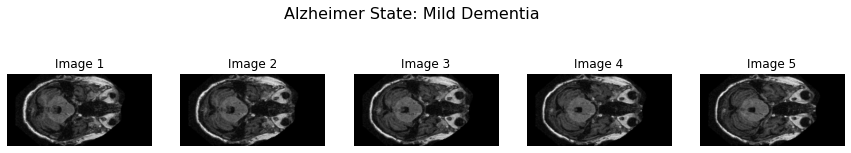

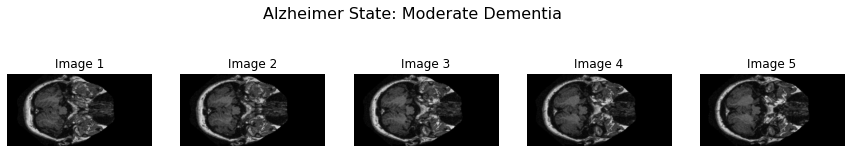

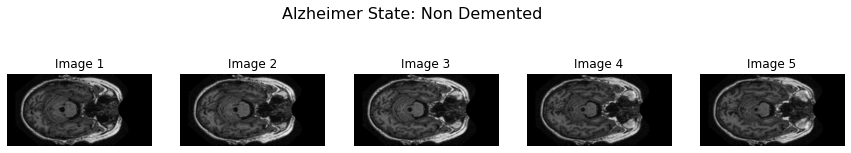

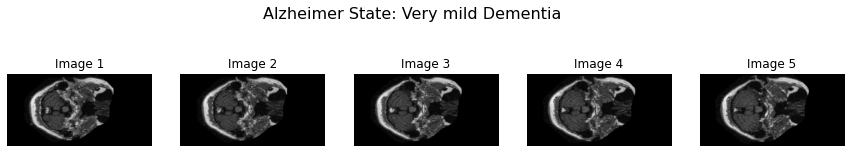

In [15]:
for folder in image_classes:
    images = [f for f in os.listdir(folder) if f.lower().endswith(('.png','.jpg'))]
    images = images[:5]

    plt.figure(figsize=(15, 3))
    plt.suptitle(f"Alzheimer State: {os.path.basename(folder)}", fontsize=16)

    for cnt, image_name in enumerate(images):
        image_location = os.path.join(



          folder, image_name)
        img = Image.open(image_location)

        plt.subplot(1, 5, cnt + 1)
        plt.imshow(img)
        plt.axis("off")
        plt.title(f"Image {cnt+1}")

    plt.show()

In [16]:
# RESNEt
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, downsample=False):
        super(ResidualBlock, self).__init__()

        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)

        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.conv3 = nn.Conv2d(out_channels, out_channels * 4, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(out_channels * 4)

        self.relu = nn.ReLU(inplace=True)
        self.downsample = None

        if downsample:
            self.downsample = nn.Sequential(
                nn.Conv2d(in_channels, out_channels * 4, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels * 4)
            )

    def forward(self, x):
        identity = x
        if self.downsample is not None:
            identity = self.downsample(x)

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        out += identity
        out = self.relu(out)

        return out


In [17]:
class ResNet50(nn.Module):
    def __init__(self, num_classes=1000):
        super(ResNet50, self).__init__()

        self.in_channels = 64
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.layer1 = self._make_layer(64, 3)
        self.layer2 = self._make_layer(128, 4, stride=2)
        self.layer3 = self._make_layer(256, 6, stride=2)
        self.layer4 = self._make_layer(512, 3, stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * 4, num_classes)

    def _make_layer(self, out_channels, blocks, stride=1):
        layers = []
        layers.append(ResidualBlock(self.in_channels, out_channels, stride, downsample=True))
        self.in_channels = out_channels * 4

        for _ in range(1, blocks):
            layers.append(ResidualBlock(self.in_channels, out_channels))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)

        return x

In [18]:
# BASE MODEL

class SimCLRTransform:
    def __init__(self):
        self.transform = T.Compose([
            T.Resize((128, 128)),
            T.RandomResizedCrop(size=128),
            T.RandomHorizontalFlip(),
            T.RandomApply([T.ColorJitter(0.4, 0.4, 0.4, 0.1)], p=0.8),
            T.RandomGrayscale(p=0.2),
            T.ToTensor(),
            T.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
        ])

    def __call__(self, x):
        return self.transform(x), self.transform(x)


In [19]:
class SimCLRModel(nn.Module):
    def __init__(self, projection_dim=128):
        super().__init__()
        resnet = ResNet50(num_classes = 4)
        self.encoder = nn.Sequential(*list(resnet.children())[:-1])
        self.projector = nn.Sequential(
            nn.Linear(2048, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, projection_dim)
        )

    def forward(self, x):
        h = self.encoder(x).squeeze()
        z = self.projector(h)
        return z

In [20]:
def nt_xent_loss(img1, img2, temperature=0.07):
    batch_size = img1.size(0)

    img1_norm = F.normalize(img1, dim=1)
    img2_norm = F.normalize(img2, dim=1)

    z = torch.cat([img1_norm, img2_norm], dim=0)

    sim = torch.matmul(z, z.T)
    sim = sim / temperature

    mask = torch.eye(2 * batch_size, dtype=torch.bool).to(z.device)
    sim = sim.masked_fill(mask, -1e9)

    positive_indices = torch.cat([torch.arange(batch_size, 2 * batch_size),
                                  torch.arange(0, batch_size)]).to(z.device)
    positives = sim[torch.arange(2 * batch_size), positive_indices]

    loss = -positives + torch.logsumexp(sim, dim=1)
    return loss.mean()


In [21]:
from torch.utils.data import Dataset
from PIL import Image
import os

class FlatImageDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_paths = [os.path.join(root_dir, fname)
                            for fname in os.listdir(root_dir)
                            if fname.lower().endswith('.jpg')]

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        img = Image.open(img_path).convert("RGB")
        if self.transform:
            return self.transform(img)
        else:
            return img


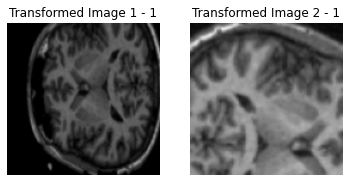

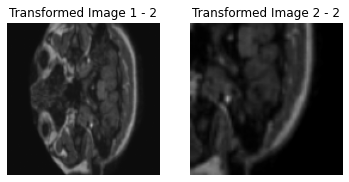

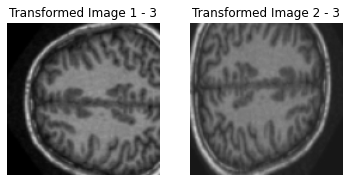

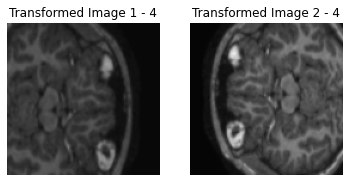

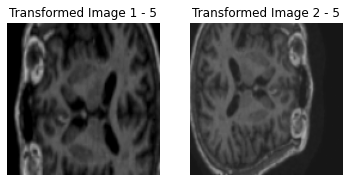

In [22]:
from torchvision.utils import make_grid

# labelled_path = "/user/rishabda/alzheimer_dataset_labelled"
# unlabelled_path = "/user/rishabda/alzheimer_dataset_unlabelled"

transform = SimCLRTransform()

unlabelled_dataset = FlatImageDataset(root_dir=unlabelled_path, transform=transform)
unlabelled_loader = DataLoader(unlabelled_dataset, batch_size=128, shuffle=True, num_workers=4)

for images in unlabelled_loader:
    image1, image2 = images

    for i in range(5):
        img1_denorm = (image1[i].permute(1,2,0) * 0.5 + 0.5)
        img2_denorm = (image2[i].permute(1,2,0) * 0.5 + 0.5)

        fig, axes = plt.subplots(1,2,figsize=(6,3))
        axes[0].imshow(img1_denorm)
        axes[0].set_title(f"Transformed Image 1 - {i+1}")
        axes[0].axis("off")

        axes[1].imshow(img2_denorm)
        axes[1].set_title(f"Transformed Image 2 - {i+1}")
        axes[1].axis("off")

        plt.show()
    break


In [ ]:
# from torchsummary import summary

# device = torch.device('cuda') if torch.cuda.is_available() else 'cpu'
# model_SimCLR = SimCLRModel().to(device)
# print(summary(model_SimCLR,(3,128,128)))

In [23]:
#. Training on Unlabelled Dataset
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_SimCLR = SimCLRModel().to(device)
optimizer = torch.optim.Adam(model_SimCLR.parameters(), lr=1e-3)
epochs = 50

simclr_losses = []

train_start_time = time.time()

for epoch in range(epochs):
    model_SimCLR.train()
    total_loss = 0

    for img1, img2 in unlabelled_loader:
        img1, img2 = img1.to(device), img2.to(device)

        pred_img1 = model_SimCLR(img1)
        pred_img2 = model_SimCLR(img2)

        loss = nt_xent_loss(pred_img1, pred_img2)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    simclr_losses.append(total_loss / len(unlabelled_loader))
    print(f"Epoch [{epoch+1}/{epochs}], Loss: {total_loss/len(unlabelled_loader):.4f}")

train_end_time = time.time()
training_time = train_end_time - train_start_time
print(f"\nTotal training time SimCLR model: {training_time:.2f} seconds")


Epoch [1/50], Loss: 4.6907
Epoch [2/50], Loss: 3.5038
Epoch [3/50], Loss: 2.6135
Epoch [4/50], Loss: 2.0486
Epoch [5/50], Loss: 1.7137
Epoch [6/50], Loss: 1.4755
Epoch [7/50], Loss: 1.3000
Epoch [8/50], Loss: 1.1971
Epoch [9/50], Loss: 1.0906
Epoch [10/50], Loss: 0.9961
Epoch [11/50], Loss: 0.9255
Epoch [12/50], Loss: 0.8716
Epoch [13/50], Loss: 0.8278
Epoch [14/50], Loss: 0.7777
Epoch [15/50], Loss: 0.7433
Epoch [16/50], Loss: 0.7032
Epoch [17/50], Loss: 0.6734
Epoch [18/50], Loss: 0.6457
Epoch [19/50], Loss: 0.6251
Epoch [20/50], Loss: 0.6000
Epoch [21/50], Loss: 0.5808
Epoch [22/50], Loss: 0.5566
Epoch [23/50], Loss: 0.5409
Epoch [24/50], Loss: 0.5287
Epoch [25/50], Loss: 0.5064
Epoch [26/50], Loss: 0.4981
Epoch [27/50], Loss: 0.4883
Epoch [28/50], Loss: 0.4764
Epoch [29/50], Loss: 0.4588
Epoch [30/50], Loss: 0.4510
Epoch [31/50], Loss: 0.4373
Epoch [32/50], Loss: 0.4248
Epoch [33/50], Loss: 0.4102
Epoch [34/50], Loss: 0.4060
Epoch [35/50], Loss: 0.4023
Epoch [36/50], Loss: 0.3885
E

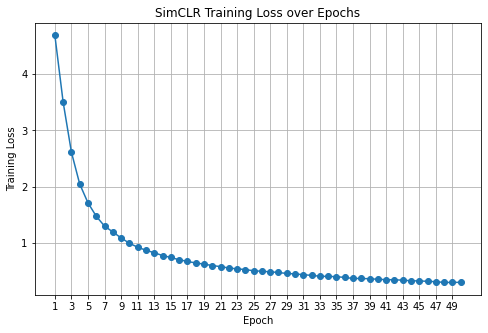

In [24]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.plot(range(1, len(simclr_losses) + 1), simclr_losses, marker='o')
plt.xlabel('Epoch')
plt.ylabel('Training Loss')
plt.title('SimCLR Training Loss over Epochs')
plt.xticks(range(1, len(simclr_losses) + 1, 2))
plt.grid(True)
plt.show()

In [25]:
save_path = "SSL_SimCLR_Hack4Health.pth"
torch.save(model_SimCLR.state_dict(), save_path)

In [26]:
simclr_finetune_train_losses      = []
simclr_finetune_val_losses        = []
simclr_finetune_train_accuracies  = []
simclr_finetune_val_accuracies    = []


def train_model(model, train_loader, val_loader, num_epochs=10):
    for epoch in range(num_epochs):
        model.train()
        total_loss, correct, total = 0, 0, 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
            _, predicted = outputs.max(1)
            correct += predicted.eq(labels).sum().item()
            total += labels.size(0)

        train_acc = 100 * correct / total
        val_acc, val_loss , all_preds, all_labels = evaluate_model(model, val_loader)

        simclr_finetune_train_losses.append(total_loss / len(train_loader))
        simclr_finetune_train_accuracies.append(train_acc)
        simclr_finetune_val_losses.append(val_loss)
        simclr_finetune_val_accuracies.append(val_acc)

        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {total_loss/len(train_loader):.4f}, Train Acc: {train_acc:.2f}%, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")

In [27]:
def evaluate_model(model, loader):
    model.eval()
    total_loss, correct, total = 0, 0, 0
    all_preds, all_labels = [], []

    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            total_loss += loss.item()
            _, predicted = outputs.max(1)
            correct += predicted.eq(labels).sum().item()
            total += labels.size(0)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    accuracy = 100 * correct / total
    return accuracy, total_loss / len(loader), all_preds, all_labels

In [28]:
def plot_confusion_matrix(all_preds, all_labels,class_names,name):
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(6,6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Predicted Alzeimer Class")
    plt.ylabel("Actual Alzeimer class")
    plt.title(f"Confusion Matrix For Classification using {name}")
    plt.show()

In [29]:
from sklearn.metrics import classification_report, accuracy_score

def performace_summary(y_true, y_pred, class_names, output_dict=True):
    report = classification_report(y_true, y_pred, target_names=class_names, output_dict=output_dict)
    overall_accuracy = accuracy_score(y_true, y_pred)

    print("\nPERFORMANCE SUMMARY")
    print("--------------------")

    for class_name in class_names:
        precision = report[class_name]["precision"]
        recall = report[class_name]["recall"]
        f1 = report[class_name]["f1-score"]
        support = report[class_name]["support"]

        print(f"Class: {class_name}")
        print(f"  Precision : {precision:.4f}")
        print(f"  Recall    : {recall:.4f}")
        print(f"  F1-Score  : {f1:.4f}")
        print(f"  Support   : {support}")
        print("--------------------")

    print("Overall Metrics:")
    print(f"  Accuracy              : {overall_accuracy:.4f}")
    print(f"  Macro Avg Precision   : {report['macro avg']['precision']:.4f}")
    print(f"  Macro Avg Recall      : {report['macro avg']['recall']:.4f}")
    print(f"  Macro Avg F1-Score    : {report['macro avg']['f1-score']:.4f}")
    print(f"  Weighted Avg Precision: {report['weighted avg']['precision']:.4f}")
    print(f"  Weighted Avg Recall   : {report['weighted avg']['recall']:.4f}")
    print(f"  Weighted Avg F1-Score : {report['weighted avg']['f1-score']:.4f}")


In [31]:
labelled_path = "/user/pgnanase/alzheimer_dataset_labelled"

transform_eval = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

dataset = datasets.ImageFolder(root=labelled_path, transform=transform_eval)

total_size = len(dataset)
train_size = int(0.7 * total_size)
val_size = int(0.15 * total_size)
test_size = total_size - train_size - val_size

train_set, val_set, test_set = random_split(dataset, [train_size, val_size, test_size], generator=torch.Generator().manual_seed(42))

train_loader_ad = DataLoader(train_set, batch_size=64, shuffle=True, num_workers=2)
val_loader_ad = DataLoader(val_set, batch_size=64, shuffle=False, num_workers=2)
test_loader_ad = DataLoader(test_set, batch_size=64, shuffle=False, num_workers=2)

num_classes = len(dataset.classes)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [32]:
class LinearClassifier(nn.Module):
    def __init__(self, encoder, num_classes):
        super().__init__()
        self.encoder = encoder
        for param in self.encoder.parameters():
            param.requires_grad = True
        self.fc = nn.Linear(2048, num_classes)

    def forward(self, x):
        features = self.encoder(x).squeeze()
        return self.fc(features)

In [33]:
# Fine Tuning on AD

model = SimCLRModel()

save_path = "/user/pgnanase/SSL_SimCLR_Hack4Health.pth"
model.load_state_dict(torch.load(save_path, map_location=device))
model.to(device)
model.eval()

encoder_weights = model.encoder

simCLR_fine_tuned_ad = LinearClassifier(encoder=encoder_weights, num_classes=num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(simCLR_fine_tuned_ad.parameters(), lr=1e-4)


In [34]:
start_time=time.time()
train_model(simCLR_fine_tuned_ad, train_loader_ad, val_loader_ad, num_epochs=100)

train_time = time.time() - start_time
print(f"\nTraining Time SimCLR-Finetuned: {train_time:.2f} seconds")

Epoch 1/100, Train Loss: 1.3310, Train Acc: 38.65%, Val Loss: 1.2715, Val Acc: 43.70%
Epoch 2/100, Train Loss: 1.1552, Train Acc: 61.27%, Val Loss: 1.1165, Val Acc: 56.67%
Epoch 3/100, Train Loss: 1.0067, Train Acc: 67.14%, Val Loss: 0.9931, Val Acc: 62.96%
Epoch 4/100, Train Loss: 0.8854, Train Acc: 69.92%, Val Loss: 0.8952, Val Acc: 65.19%
Epoch 5/100, Train Loss: 0.7651, Train Acc: 75.56%, Val Loss: 0.8005, Val Acc: 66.30%
Epoch 6/100, Train Loss: 0.6659, Train Acc: 78.97%, Val Loss: 0.7281, Val Acc: 67.04%
Epoch 7/100, Train Loss: 0.5849, Train Acc: 81.90%, Val Loss: 0.6645, Val Acc: 71.85%
Epoch 8/100, Train Loss: 0.5052, Train Acc: 83.25%, Val Loss: 0.6451, Val Acc: 71.48%
Epoch 9/100, Train Loss: 0.4523, Train Acc: 85.87%, Val Loss: 0.5852, Val Acc: 73.70%
Epoch 10/100, Train Loss: 0.3906, Train Acc: 88.41%, Val Loss: 0.5483, Val Acc: 76.30%
Epoch 11/100, Train Loss: 0.3417, Train Acc: 90.08%, Val Loss: 0.5132, Val Acc: 78.89%
Epoch 12/100, Train Loss: 0.2977, Train Acc: 90.79%,

In [35]:
test_accuracy_simclr_ad, test_loss_simclr_ad, all_preds_simclr_ad, all_labels_simclr_ad = evaluate_model(simCLR_fine_tuned_ad, test_loader_ad)
print(f"Test Loss: {test_loss_simclr_ad:.4f}, Test Accuracy: {test_accuracy_simclr_ad:.2f}%")


Test Loss: 0.8003, Test Accuracy: 87.41%


In [36]:
print("Classification Report:\n", classification_report(all_labels_simclr_ad, all_preds_simclr_ad, target_names=dataset.classes))
performace_summary(all_labels_simclr_ad, all_preds_simclr_ad, dataset.classes)

Classification Report:
                     precision    recall  f1-score   support

     Mild Dementia       0.86      0.89      0.88        76
 Moderate Dementia       0.94      1.00      0.97        58
      Non Demented       0.89      0.83      0.86        69
Very mild Dementia       0.82      0.79      0.80        67

          accuracy                           0.87       270
         macro avg       0.88      0.88      0.88       270
      weighted avg       0.87      0.87      0.87       270


PERFORMANCE SUMMARY
--------------------
Class: Mild Dementia
  Precision : 0.8608
  Recall    : 0.8947
  F1-Score  : 0.8774
  Support   : 76
--------------------
Class: Moderate Dementia
  Precision : 0.9355
  Recall    : 1.0000
  F1-Score  : 0.9667
  Support   : 58
--------------------
Class: Non Demented
  Precision : 0.8906
  Recall    : 0.8261
  F1-Score  : 0.8571
  Support   : 69
--------------------
Class: Very mild Dementia
  Precision : 0.8154
  Recall    : 0.7910
  F1-Score  : 

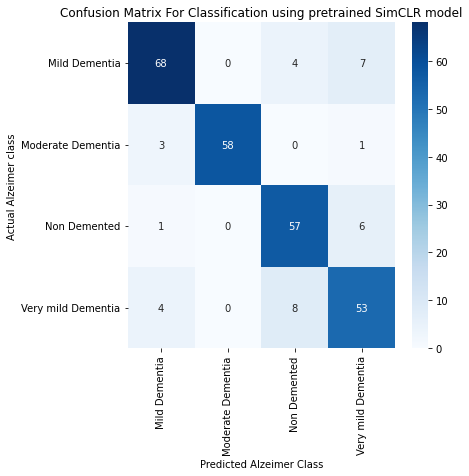

In [37]:
plot_confusion_matrix(all_labels_simclr_ad, all_preds_simclr_ad,dataset.classes,"pretrained SimCLR model")

In [38]:
torch.save(simCLR_fine_tuned_ad.state_dict(), "SSL_SimCLR_AD_Hack4health.pth")

In [43]:
#Brain Tumor

tumor_labelled_path = "/user/pgnanase/brain-tumor-mri-dataset/Testing"

In [44]:
print("TUMOR DATASET")
print("-----------------")

for class_name in os.listdir(tumor_labelled_path):
    class_folder = os.path.join(tumor_labelled_path, class_name)
    if os.path.isdir(class_folder):
        num_images = len([f for f in os.listdir(class_folder) if f.lower().endswith(('.jpg'))])
        print(f"  - {class_name}: {num_images} images")

# unlabelled_images = [f for f in os.listdir(unlabelled_path) if f.lower().endswith('.jpg')]

TUMOR DATASET
-----------------
  - glioma: 450 images
  - meningioma: 450 images
  - notumor: 450 images
  - pituitary: 450 images


In [45]:
transform_eval = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

dataset = datasets.ImageFolder(root=tumor_labelled_path, transform=transform_eval)

total_size = len(dataset)
train_size = int(0.7 * total_size)
val_size = int(0.15 * total_size)
test_size = total_size - train_size - val_size

train_set, val_set, test_set = random_split(dataset, [train_size, val_size, test_size], generator=torch.Generator().manual_seed(42))

train_loader_bt = DataLoader(train_set, batch_size=64, shuffle=True, num_workers=2)
val_loader_bt = DataLoader(val_set, batch_size=64, shuffle=False, num_workers=2)
test_loader_bt = DataLoader(test_set, batch_size=64, shuffle=False, num_workers=2)

num_classes = len(dataset.classes)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [47]:
model = SimCLRModel()

save_path = "/user/pgnanase/SSL_SimCLR_Hack4Health.pth"
model.load_state_dict(torch.load(save_path, map_location=device))
model.to(device)
model.eval()

encoder_weights = model.encoder

simCLR_fine_tuned_bt = LinearClassifier(encoder=encoder_weights, num_classes=num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(simCLR_fine_tuned_bt.parameters(), lr=1e-4)


In [48]:
start_time=time.time()
train_model(simCLR_fine_tuned_bt, train_loader_bt, val_loader_bt, num_epochs=15)

train_time = time.time() - start_time
print(f"\nTraining Time SimCLR-Finetuned: {train_time:.2f} seconds")

Epoch 1/15, Train Loss: 1.2789, Train Acc: 50.71%, Val Loss: 1.1632, Val Acc: 68.52%
Epoch 2/15, Train Loss: 1.0574, Train Acc: 75.63%, Val Loss: 0.9152, Val Acc: 77.78%
Epoch 3/15, Train Loss: 0.8514, Train Acc: 80.40%, Val Loss: 0.7225, Val Acc: 83.70%
Epoch 4/15, Train Loss: 0.6650, Train Acc: 83.25%, Val Loss: 0.5751, Val Acc: 85.19%
Epoch 5/15, Train Loss: 0.5229, Train Acc: 85.95%, Val Loss: 0.4776, Val Acc: 87.41%
Epoch 6/15, Train Loss: 0.4177, Train Acc: 87.94%, Val Loss: 0.4072, Val Acc: 87.04%
Epoch 7/15, Train Loss: 0.3319, Train Acc: 91.27%, Val Loss: 0.3474, Val Acc: 88.89%
Epoch 8/15, Train Loss: 0.2654, Train Acc: 92.94%, Val Loss: 0.3082, Val Acc: 88.89%
Epoch 9/15, Train Loss: 0.2176, Train Acc: 94.37%, Val Loss: 0.2688, Val Acc: 90.00%
Epoch 10/15, Train Loss: 0.1663, Train Acc: 95.79%, Val Loss: 0.2423, Val Acc: 91.85%
Epoch 11/15, Train Loss: 0.1310, Train Acc: 97.30%, Val Loss: 0.2225, Val Acc: 91.85%
Epoch 12/15, Train Loss: 0.1024, Train Acc: 98.17%, Val Loss: 0

In [49]:
test_accuracy_simclr_bt, test_loss_simclr_bt, all_preds_simclr_b, all_labels_simclr_bt = evaluate_model(simCLR_fine_tuned_bt, test_loader_bt)
print(f"Test Loss: {test_loss_simclr_bt:.4f}, Test Accuracy: {test_accuracy_simclr_bt:.2f}%")

Test Loss: 0.2142, Test Accuracy: 92.59%


In [50]:
print("Classification Report:\n", classification_report(all_labels_simclr_bt, all_preds_simclr_b, target_names=dataset.classes))
performace_summary(all_labels_simclr_bt, all_preds_simclr_b, dataset.classes)

Classification Report:
               precision    recall  f1-score   support

      glioma       0.96      0.89      0.93        76
  meningioma       0.86      0.84      0.85        58
     notumor       0.96      1.00      0.98        69
   pituitary       0.91      0.96      0.93        67

    accuracy                           0.93       270
   macro avg       0.92      0.92      0.92       270
weighted avg       0.93      0.93      0.93       270


PERFORMANCE SUMMARY
--------------------
Class: glioma
  Precision : 0.9577
  Recall    : 0.8947
  F1-Score  : 0.9252
  Support   : 76
--------------------
Class: meningioma
  Precision : 0.8596
  Recall    : 0.8448
  F1-Score  : 0.8522
  Support   : 58
--------------------
Class: notumor
  Precision : 0.9583
  Recall    : 1.0000
  F1-Score  : 0.9787
  Support   : 69
--------------------
Class: pituitary
  Precision : 0.9143
  Recall    : 0.9552
  F1-Score  : 0.9343
  Support   : 67
--------------------
Overall Metrics:
  Accuracy    

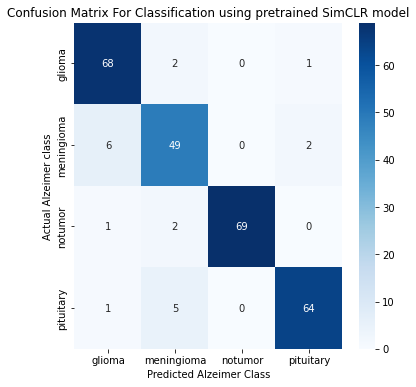

In [51]:
plot_confusion_matrix(all_labels_simclr_bt, all_preds_simclr_b,dataset.classes,"pretrained SimCLR model")

In [52]:
torch.save(simCLR_fine_tuned_bt.state_dict(), "SSL_SimCLR_BT_Hack4Health.pth")

In [55]:
# Multiple Sclerosis

multiple_sclerosis_labelled_path = "/user/pgnanase/ms_slices_central"

In [56]:
print("MULTIPLE SCLEROSIS DATASET")
print("-----------------")

for class_name in os.listdir(multiple_sclerosis_labelled_path):
    class_folder = os.path.join(multiple_sclerosis_labelled_path, class_name)
    if os.path.isdir(class_folder):
        num_images = len([f for f in os.listdir(class_folder) if f.lower().endswith(('.jpg','.png'))])
        print(f"  - {class_name}: {num_images} images")

# unlabelled_images = [f for f in os.listdir(unlabelled_path) if f.lower().endswith('.jpg')]

MULTIPLE SCLEROSIS DATASET
-----------------
  - MS: 203 images
  - Normal: 217 images


In [57]:
transform_eval = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

dataset = datasets.ImageFolder(root=multiple_sclerosis_labelled_path, transform=transform_eval)

total_size = len(dataset)
train_size = int(0.7 * total_size)
val_size = int(0.15 * total_size)
test_size = total_size - train_size - val_size

train_set, val_set, test_set = random_split(dataset, [train_size, val_size, test_size], generator=torch.Generator().manual_seed(42))

train_loader_ms = DataLoader(train_set, batch_size=64, shuffle=True, num_workers=2)
val_loader_ms = DataLoader(val_set, batch_size=64, shuffle=False, num_workers=2)
test_loader_ms = DataLoader(test_set, batch_size=64, shuffle=False, num_workers=2)

num_classes = len(dataset.classes)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [58]:
model = SimCLRModel()

save_path = "/user/pgnanase/SSL_SimCLR_Hack4Health.pth"
model.load_state_dict(torch.load(save_path, map_location=device))
model.to(device)
model.eval()

encoder_weights = model.encoder

simCLR_fine_tuned_ms = LinearClassifier(encoder=encoder_weights, num_classes=num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(simCLR_fine_tuned_ms.parameters(), lr=1e-4)


In [59]:
start_time=time.time()
train_model(simCLR_fine_tuned_ms, train_loader_ms, val_loader_ms, num_epochs=20)

train_time = time.time() - start_time
print(f"\nTraining Time SimCLR-Finetuned: {train_time:.2f} seconds")

Epoch 1/20, Train Loss: 0.6789, Train Acc: 56.46%, Val Loss: 0.6835, Val Acc: 61.90%
Epoch 2/20, Train Loss: 0.6477, Train Acc: 65.65%, Val Loss: 0.6518, Val Acc: 71.43%
Epoch 3/20, Train Loss: 0.6170, Train Acc: 72.11%, Val Loss: 0.6193, Val Acc: 74.60%
Epoch 4/20, Train Loss: 0.5865, Train Acc: 76.87%, Val Loss: 0.5889, Val Acc: 85.71%
Epoch 5/20, Train Loss: 0.5568, Train Acc: 80.61%, Val Loss: 0.5602, Val Acc: 84.13%
Epoch 6/20, Train Loss: 0.5238, Train Acc: 84.69%, Val Loss: 0.5256, Val Acc: 85.71%
Epoch 7/20, Train Loss: 0.4943, Train Acc: 87.41%, Val Loss: 0.4952, Val Acc: 84.13%
Epoch 8/20, Train Loss: 0.4665, Train Acc: 90.82%, Val Loss: 0.4626, Val Acc: 87.30%
Epoch 9/20, Train Loss: 0.4208, Train Acc: 90.82%, Val Loss: 0.4328, Val Acc: 90.48%
Epoch 10/20, Train Loss: 0.3833, Train Acc: 93.54%, Val Loss: 0.4009, Val Acc: 90.48%
Epoch 11/20, Train Loss: 0.3443, Train Acc: 93.54%, Val Loss: 0.3781, Val Acc: 90.48%
Epoch 12/20, Train Loss: 0.3076, Train Acc: 96.26%, Val Loss: 0

In [60]:
test_accuracy_simclr_ms, test_loss_simclr_ms, all_preds_simclr_ms, all_labels_simclr_ms = evaluate_model(simCLR_fine_tuned_ms, test_loader_ms)
print(f"Test Loss: {test_loss_simclr_ms:.4f}, Test Accuracy: {test_accuracy_simclr_ms:.2f}%")

Test Loss: 0.2424, Test Accuracy: 87.30%


In [61]:
print("Classification Report:\n", classification_report(all_labels_simclr_ms, all_preds_simclr_ms, target_names=dataset.classes))
performace_summary(all_labels_simclr_ms, all_preds_simclr_ms, dataset.classes)

Classification Report:
               precision    recall  f1-score   support

          MS       0.93      0.81      0.86        31
      Normal       0.83      0.94      0.88        32

    accuracy                           0.87        63
   macro avg       0.88      0.87      0.87        63
weighted avg       0.88      0.87      0.87        63


PERFORMANCE SUMMARY
--------------------
Class: MS
  Precision : 0.9259
  Recall    : 0.8065
  F1-Score  : 0.8621
  Support   : 31
--------------------
Class: Normal
  Precision : 0.8333
  Recall    : 0.9375
  F1-Score  : 0.8824
  Support   : 32
--------------------
Overall Metrics:
  Accuracy              : 0.8730
  Macro Avg Precision   : 0.8796
  Macro Avg Recall      : 0.8720
  Macro Avg F1-Score    : 0.8722
  Weighted Avg Precision: 0.8789
  Weighted Avg Recall   : 0.8730
  Weighted Avg F1-Score : 0.8724


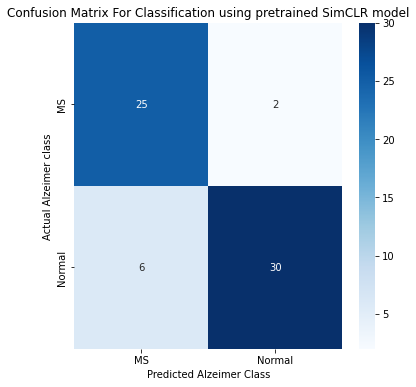

In [62]:
plot_confusion_matrix(all_labels_simclr_ms, all_preds_simclr_ms,dataset.classes,"pretrained SimCLR model")

In [63]:
torch.save(simCLR_fine_tuned_ms.state_dict(), "SSL_SimCLR_MS_Hack4Health.pth")

In [64]:
# Parkinson

parkinson_labelled_path = "/user/pgnanase/parkinsons_dataset_processed"

In [65]:
for class_name in os.listdir(parkinson_labelled_path):
    class_folder = os.path.join(parkinson_labelled_path, class_name)
    if os.path.isdir(class_folder):
        upsample_class_images(class_folder, target_count=450)

In [66]:
print("PARKINSON DATASET")
print("-----------------")

for class_name in os.listdir(parkinson_labelled_path):
    class_folder = os.path.join(parkinson_labelled_path, class_name)
    if os.path.isdir(class_folder):
        num_images = len([f for f in os.listdir(class_folder) if f.lower().endswith(('.jpg','.png'))])
        print(f"  - {class_name}: {num_images} images")

# unlabelled_images = [f for f in os.listdir(unlabelled_path) if f.lower().endswith('.jpg')]

PARKINSON DATASET
-----------------
  - normal: 450 images
  - parkinson: 450 images


In [67]:
transform_eval = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

dataset = datasets.ImageFolder(root=parkinson_labelled_path, transform=transform_eval)

total_size = len(dataset)
train_size = int(0.7 * total_size)
val_size = int(0.15 * total_size)
test_size = total_size - train_size - val_size

train_set, val_set, test_set = random_split(dataset, [train_size, val_size, test_size], generator=torch.Generator().manual_seed(42))

train_loader_pk = DataLoader(train_set, batch_size=64, shuffle=True, num_workers=2)
val_loader_pk = DataLoader(val_set, batch_size=64, shuffle=False, num_workers=2)
test_loader_pk = DataLoader(test_set, batch_size=64, shuffle=False, num_workers=2)

num_classes = len(dataset.classes)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [69]:
model = SimCLRModel()

save_path = "/user/pgnanase/SSL_SimCLR_Hack4Health.pth"
model.load_state_dict(torch.load(save_path, map_location=device))
model.to(device)
model.eval()

encoder_weights = model.encoder

simCLR_fine_tuned_pk = LinearClassifier(encoder=encoder_weights, num_classes=num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(simCLR_fine_tuned_pk.parameters(), lr=1e-4)


In [70]:
start_time=time.time()
train_model(simCLR_fine_tuned_pk, train_loader_pk, val_loader_pk, num_epochs=10)

train_time = time.time() - start_time
print(f"\nTraining Time SimCLR-Finetuned: {train_time:.2f} seconds")

Epoch 1/10, Train Loss: 0.6343, Train Acc: 68.41%, Val Loss: 0.6483, Val Acc: 63.70%
Epoch 2/10, Train Loss: 0.5024, Train Acc: 89.68%, Val Loss: 0.4788, Val Acc: 91.85%
Epoch 3/10, Train Loss: 0.3977, Train Acc: 94.60%, Val Loss: 0.3609, Val Acc: 96.30%
Epoch 4/10, Train Loss: 0.3019, Train Acc: 96.35%, Val Loss: 0.2641, Val Acc: 97.04%
Epoch 5/10, Train Loss: 0.2220, Train Acc: 97.30%, Val Loss: 0.1995, Val Acc: 97.04%
Epoch 6/10, Train Loss: 0.1722, Train Acc: 97.78%, Val Loss: 0.1474, Val Acc: 99.26%
Epoch 7/10, Train Loss: 0.1228, Train Acc: 98.73%, Val Loss: 0.1116, Val Acc: 99.26%
Epoch 8/10, Train Loss: 0.0903, Train Acc: 99.37%, Val Loss: 0.0816, Val Acc: 99.26%
Epoch 9/10, Train Loss: 0.0711, Train Acc: 99.52%, Val Loss: 0.0595, Val Acc: 99.26%
Epoch 10/10, Train Loss: 0.0490, Train Acc: 100.00%, Val Loss: 0.0461, Val Acc: 99.26%

Training Time SimCLR-Finetuned: 16.44 seconds


In [71]:
test_accuracy_simclr_pk, test_loss_simclr_pk, all_preds_simclr_pk, all_labels_simclr_pk = evaluate_model(simCLR_fine_tuned_pk, test_loader_pk)
print(f"Test Loss: {test_loss_simclr_pk:.4f}, Test Accuracy: {test_accuracy_simclr_pk:.2f}%")

Test Loss: 0.0542, Test Accuracy: 99.26%


In [72]:
print("Classification Report:\n", classification_report(all_labels_simclr_pk, all_preds_simclr_pk, target_names=dataset.classes))
performace_summary(all_labels_simclr_pk, all_preds_simclr_pk, dataset.classes)

Classification Report:
               precision    recall  f1-score   support

      normal       1.00      0.99      0.99        68
   parkinson       0.99      1.00      0.99        67

    accuracy                           0.99       135
   macro avg       0.99      0.99      0.99       135
weighted avg       0.99      0.99      0.99       135


PERFORMANCE SUMMARY
--------------------
Class: normal
  Precision : 1.0000
  Recall    : 0.9853
  F1-Score  : 0.9926
  Support   : 68
--------------------
Class: parkinson
  Precision : 0.9853
  Recall    : 1.0000
  F1-Score  : 0.9926
  Support   : 67
--------------------
Overall Metrics:
  Accuracy              : 0.9926
  Macro Avg Precision   : 0.9926
  Macro Avg Recall      : 0.9926
  Macro Avg F1-Score    : 0.9926
  Weighted Avg Precision: 0.9927
  Weighted Avg Recall   : 0.9926
  Weighted Avg F1-Score : 0.9926


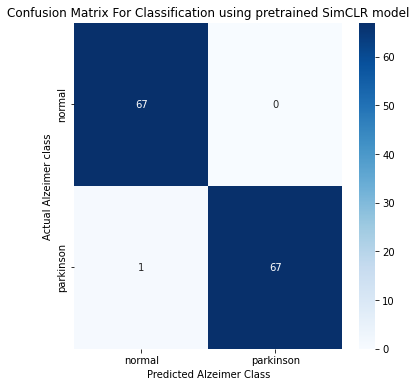

In [73]:
plot_confusion_matrix(all_labels_simclr_pk, all_preds_simclr_pk,dataset.classes,"pretrained SimCLR model")

In [74]:
torch.save(simCLR_fine_tuned_pk.state_dict(), "SSL_SimCLR_PK_Hack4Health.pth")

In [76]:
# GradCAM


!pip install grad-cam

Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 7.8 MB 5.1 MB/s eta 0:00:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 67.0 MB 116.3 MB/s eta 0:00:01
  Using cached numpy-2.0.2-cp39-cp39-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (19.5 MB)
     |████████████████████████████████| 38.6 MB 48.3 MB/s eta 0:00:01
  Created wheel for grad-cam: filename=grad_cam-1.5.5-py3-none-any.whl size=44284 sha256=eadbcdb68893aa38ebe5a1521aa63a3c10dec997ebd869a60d30afa6746d0a25
  Stored in directory: /user/pgnanase/.cache/pip/wheels/04/e1/f6/1c65b156ed8aaddabf0ef7f91334f7cdb11f43f84abf403138
Successfully built grad-cam


In [77]:
import numpy as np
import random
import matplotlib.pyplot as plt
import cv2
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image

In [78]:
import torch
import torch.nn as nn

class WrappedModel(nn.Module):
    def __init__(self, model):
        super().__init__()
        self.model = model

    def forward(self, x):
        out = self.model(x)
        if out.dim() == 1:
            out = out.unsqueeze(0)
        return out


In [90]:
def run_gradcam(model, dataloader, class_names, device, num_samples=3):
    wrapped_model = WrappedModel(model).to(device)
    target_layer = [wrapped_model.model.encoder[7][-1]]
    cam = GradCAM(model=wrapped_model, target_layers=target_layer)

    dataset = dataloader.dataset
    indices = list(range(len(dataset)))
    random.shuffle(indices) 

    count = 0
    for idx in indices:
        image, label = dataset[idx]
        input_tensor = image.unsqueeze(0).to(device)
        true_label = label

        img = image.permute(1, 2, 0).cpu().numpy()
        img = (img * 0.5) + 0.5
        img = np.clip(img, 0, 1)

        wrapped_model.eval()
        with torch.no_grad():
            logits = wrapped_model(input_tensor)
            probs = torch.nn.functional.softmax(logits, dim=1)
            pred_class = torch.argmax(probs, dim=1).item()
            confidence_score = probs[0, pred_class].item()

        
        targets = [ClassifierOutputTarget(pred_class)]
        grayscale_cam = cam(input_tensor=input_tensor, targets=targets)[0]

       
        activation_intensity_score = float(np.mean(grayscale_cam))
        activation_area_pct = float(np.sum(grayscale_cam > 0.5) / grayscale_cam.size * 100)
        heatmap_img = show_cam_on_image(img, grayscale_cam, use_rgb=True)

     
        fig, axs = plt.subplots(1, 2, figsize=(10, 4))
        axs[0].imshow(img)
        axs[0].set_title(f"Original\nTrue: {class_names[true_label]}")
        axs[0].axis('off')

        axs[1].imshow(heatmap_img)
        axs[1].set_title(f"Grad-CAM\nPredicted: {class_names[pred_class]}")
        axs[1].axis('off')

        plt.tight_layout()
        plt.show()

    
        print("Grad-CAM Metrics")
        print(f"Predicted Class         : {class_names[pred_class]}")
        print(f"Confidence Score        : {confidence_score:.4f}")
        print(f"Activation Intensity    : {activation_intensity_score:.4f}")
        print(f"Activation Area > 0.5   : {activation_area_pct:.2f}%")
        print("-" * 50)

        count += 1
        if count >= num_samples:
            return


In [91]:
class_names_ad = train_loader_ad.dataset.dataset.classes
class_names_bt = train_loader_bt.dataset.dataset.classes
class_names_ms = train_loader_ms.dataset.dataset.classes
class_names_pk = train_loader_pk.dataset.dataset.classes


Grad-CAM for Alzheimer


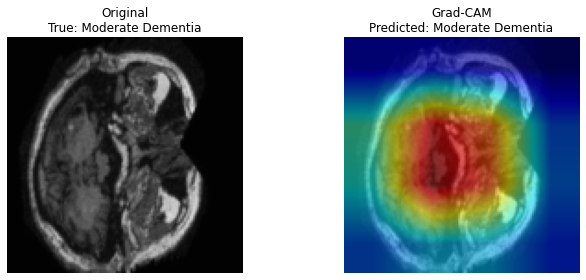

Grad-CAM Metrics
Predicted Class         : Moderate Dementia
Confidence Score        : 1.0000
Activation Intensity    : 0.3784
Activation Area > 0.5   : 28.10%
--------------------------------------------------

Grad-CAM for Tumor


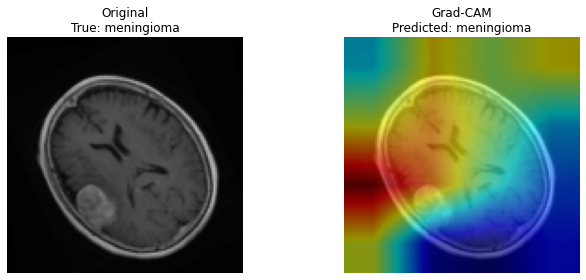

Grad-CAM Metrics
Predicted Class         : meningioma
Confidence Score        : 0.9904
Activation Intensity    : 0.4714
Activation Area > 0.5   : 52.98%
--------------------------------------------------

Grad-CAM for MS


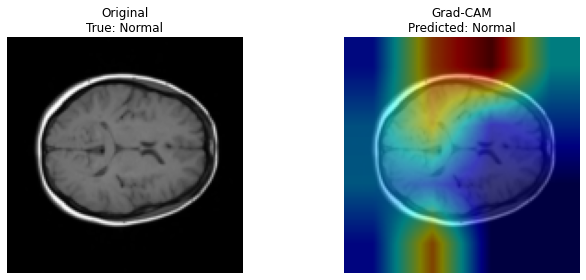

Grad-CAM Metrics
Predicted Class         : Normal
Confidence Score        : 0.8269
Activation Intensity    : 0.3080
Activation Area > 0.5   : 20.95%
--------------------------------------------------

Grad-CAM for Parkinson


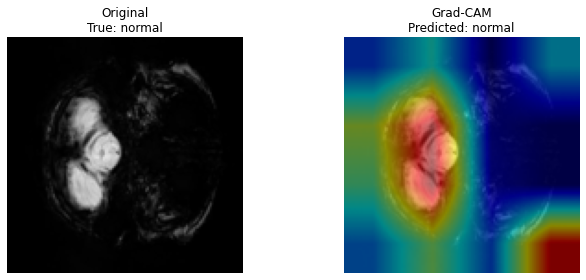

Grad-CAM Metrics
Predicted Class         : normal
Confidence Score        : 0.9614
Activation Intensity    : 0.3714
Activation Area > 0.5   : 29.45%
--------------------------------------------------


In [92]:
disease_models = {
    "Alzheimer": (simCLR_fine_tuned_ad, test_loader_ad, class_names_ad),
    "Tumor": (simCLR_fine_tuned_bt, test_loader_bt, class_names_bt),
    "MS": (simCLR_fine_tuned_ms, test_loader_ms, class_names_ms),
    "Parkinson": (simCLR_fine_tuned_pk, test_loader_pk, class_names_pk)
}


for disease, (model, loader, class_names) in disease_models.items():
    print(f"\nGrad-CAM for {disease}")
    run_gradcam(model, loader, class_names, device, num_samples=1)
